In [1]:
import pandas as pd
import numpy as np

def get_data(file):
    data = pd.read_csv(file, sep='\t', skiprows=2, index_col=0)
    data = data.drop(['Description'], axis=1)
    return data

counts = get_data('../data/counts.gct')
counts = counts[np.all(counts != 0, axis=1)]

rpkm = get_data('../data/rpkms.gct')
rpkm = rpkm.loc[counts.index]

meta = pd.read_csv('../data/meta.txt', sep='\t', skiprows=31, index_col=0)
meta.shape

(44, 57)

In [2]:
import scipy.stats as stats

def normalize(data):
    means = stats.mstats.gmean(data, axis=1)
    ratios = data / np.tile(means, (len(data.columns), 1)).T
    medians = np.median(ratios, axis=0)
    return data / np.tile(medians, (len(data), 1))

normal = normalize(counts)
normal.shape

(4297, 57)

In [3]:
def log(x):
    return np.log2(x + 1)

dmso = meta.columns[meta.loc['!Sample_source_name_ch1'] == 'DMSO']

dfs = [normal, rpkm, counts]
data = [log(np.array(i[dmso].T)) for i in dfs]
data = np.concatenate(data).T
data.shape

(4297, 18)

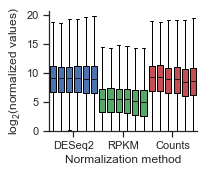

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', rc={'font.sans-serif':'Arial'})

plt.figure(figsize=(3, 2.5))
box = plt.boxplot(data, whis=(0, 100), widths=0.75, medianprops=dict(color='k'),
            patch_artist=True)
plt.ylim(0,)

for i in range(len(box['boxes'])):
    patch = box['boxes'][i]
    if i < 6:
        patch.set(facecolor='C0')
    elif i >=6 and i < 12:
        patch.set(facecolor='C2')
    else:
        patch.set(facecolor='C3')

plt.xticks([3.5, 9.5, 15.5], ['DESeq2', 'RPKM', 'Counts'])
plt.ylabel('log$\mathregular{_2}$(normalized values)')
plt.xlabel('Normalization method')
sns.despine()
plt.tight_layout()
plt.savefig('../figs/preproc1.png', dpi=300)

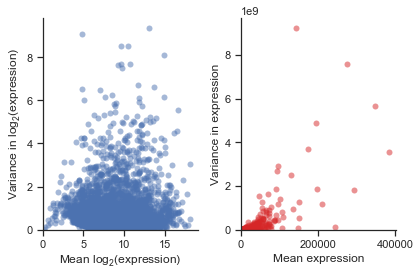

In [5]:
import scipy.stats as stats

y1 = np.var(log(normal[:]), axis=1)
x1 = np.mean(log(normal[:]), axis=1)

limit = -1
y2 = np.var(normal[dmso][:limit], axis=1)
x2 = np.mean(normal[dmso][:limit], axis=1)

plt.subplot(121)
plt.scatter(x1, y1, alpha=0.5, linewidths=0)
plt.xlabel('Mean log$\mathregular{_2}$(expression)')
plt.ylabel('Variance in log$\mathregular{_2}$(expression)')
plt.ylim(0,)
plt.xlim(0,)

plt.subplot(122)
plt.scatter(x2, y2, alpha=0.5, c='#d62728', linewidths=0)
plt.xlabel('Mean expression')
plt.ylabel('Variance in expression')
plt.ylim(0,)
plt.xlim(0,)
sns.despine()
plt.tight_layout()
plt.savefig('../figs/preproc2.png', dpi=300)
plt.show()

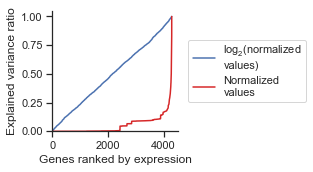

In [6]:
ordered = normal.iloc[np.argsort(x1)]
y1 = np.cumsum(np.var(ordered, axis=1))
y1 /= max(y1)
y2 = np.cumsum(np.var(log(ordered), axis=1))
y2 /= max(y2)

plt.figure(figsize=(4.5, 2.5))
plt.plot(range(len(ordered)), y2, label='log$\mathregular{_2}$(normalized\nvalues)')
plt.plot(range(len(ordered)), y1, c='#d62728', label='Normalized\nvalues')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.ylabel('Explained variance ratio')
plt.xlabel('Genes ranked by expression')
plt.xlim(0,)
plt.ylim(0,)

sns.despine()
plt.tight_layout()
plt.savefig('../figs/preproc3.png', dpi=300)
plt.show()